# Policy gradient basics

This notebook aims to describe the basics of learning a policy based on gradients. We will go through the math as well as the code and implement a learning algorithm which we will run on a simple environment.
This notebook is highly inspired by [SpinningUp from OpenAI](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html), but aims to bring the code and the math better together.

#### Recap
We have an environment in which the agent can act. At time $t$, the agent observes the state $s_t$, performs an action $a_t$, which yields a reward $r_t$ and the environment transitions to state $s_{t+1}$.

Collecting a episode or trajectory $\tau$ means acting in the environment until it is 'terminated' (task fails or succeeds) or until a prespecified limit, in which case the trajectory is 'truncated'.

It is common to sum the rewards received in a episode. We call this the 'return' of the episode: $R(\tau) = \sum_{t=0}^T r_t$.

### Policy

A policy is a function that maps an observation at time $t$ to an action *distribution*. A policy is often denoted with $\pi$.

With this we can note the probability of action $a_t$ given $s_t$ as: $\pi(a_t | s_t)$.

When learning a policy, it means the policy is parametrized, i.e. we need to learn the parameters of the function (in the case of neural networks these are its weights). We denote parameters as $\theta$, and a parametrized policy as $\pi_{\theta}$.

In [1]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
torch.manual_seed(13)

from IPython import display

In [2]:
class DiscretePolicy(nn.Module):
    def __init__(self, observation_size, actions_size, layer_sizes=[32]):
        super().__init__()

        layer_sizes = [observation_size] + layer_sizes

        layers = []
        for layer_in, layer_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(layer_in, layer_out))
            layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.output = nn.Linear(layer_sizes[-1], actions_size)

    def forward(self, x):
        logits = self.output(self.net(x))
        return logits

    def get_action_distribution(self, observations):
        return Categorical(logits=self(torch.as_tensor(observations, dtype=torch.float32)))

In [3]:
env = TimeLimit(gym.make('CartPole-v1', render_mode="rgb_array"), max_episode_steps=300)

In [4]:
policy = DiscretePolicy(
    observation_size=env.observation_space.shape[0],
    actions_size=env.action_space.n,
    layer_sizes=[32],
)

So, now we have a policy that takes as input an observation, and outputs so called *logits*. *logits* in this case will represent an *unnormalized action distribution*, i.e. the values of the probabilities before they are turned into actual probabilities.

Let's try it out.

In [5]:
obs, _ = env.reset(seed=13)
obs

array([ 0.03647976,  0.03553025,  0.03110234, -0.02385536], dtype=float32)

In [6]:
with torch.no_grad():
    logits = policy(torch.as_tensor(obs, dtype=torch.float32))
logits

tensor([ 0.4299, -0.0215])

These two values stand for the two different actions we can take. We can put them into a (categorical, because our environment requires discrete actions) distribution and sample from it.

In [7]:
action_distribution = Categorical(logits=logits)
action_distribution.probs

tensor([0.6110, 0.3890])

This shows us that with our current policy $\pi_\theta$, and given observation $s_t$, we have a 61% probability of taking action 0 (pushing to the left) and 39% probability of taking action 1 (pushing to the right). Mathematically:

$$
\pi_\theta(a_0 | s_t) = 0.611
$$
$$
\pi_\theta(a_1 | s_t) = 0.389
$$

Finally, we can also easily calculate the log probability of a sample action for this policy (these will be needed during optimization):

In [8]:
action = action_distribution.sample()
print("Action:", action)
print("Logprob:", action_distribution.log_prob(action))

Action: tensor(1)
Logprob: tensor(-0.9441)


### How to learn a policy?

Up until now stuff looks pretty similar to the more well known supervised learning situation, in which we also create a neural network that outputs probabilities in the case of classification. However, the fundamental learning algorithm is quite different. In order to understand it, we will go through the mathematics of learning a policy.


The first thing to realize is that we have no 'ground truth' policy. As opposed to supervised learning, we do not know what the output of the policy, the neural network, should be. As a result, we can only learn what is 'good' by acting in the environment, which gives us 'rewards' in return. In other words, we learn by gathering experience.

The following derivation is taken quite literally from [SpinningUp OpenAI](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

Suppose we gather the experience for one episode. This means we get a set of observations, actions and rewards. If we look at the return of the episode, $R(\tau)$, we get an overall idea of how 'well' the policy did.

We can also state that the return is dependent on the policy $\pi_\theta$, and thus on the parameters of the policy. This means we can maximize this for this. Mathematically speaking, we want to maximize $J(\pi)$:

$$
J(\pi_\theta) = \int_{\tau} P(\tau | \pi_\theta) R(\tau) = \underset{\tau \sim \pi_\theta}{\mathbb{E}}[R(\tau)]
$$

In words: we want to maximize the expected return of an episode given a certain policy. The integral expresses this as for every episode that is possible, the probability of that episode happening given the policy times the return of that episode.

Our key question actually now is: *How should we change the parameters $\theta$ of $\pi_\theta$, in order to maximize the expected return?* This is similar to the supervised learning case where we want to change the parameters in order to match the expected output. And it turns out this step in the reinforcement learning case can also be expressed with gradients:

$$
\nabla_\theta J(\pi_\theta) = \nabla_\theta \underset{\tau \sim \pi_\theta}{\mathbb{E}}[R(\tau)]
$$

Instead of the expectation we can write it as an integral:

$$
 = \nabla_\theta \int_{\tau} P(\tau | \pi_\theta) R(\tau)
$$

Now, because the return of an episode is not dependent on the parameters (only on the environment), we can bring the gradient in:

$$
 = \int_{\tau} \nabla_\theta P(\tau | \pi_\theta) R(\tau)
$$

This inner gradient of a probability $\nabla_\theta P(\tau | \pi)$ can be rewritten using the [log derivative trick](https://andrewcharlesjones.github.io/journal/log-derivative.html):

$$
 = \int_{\tau} P(\tau | \pi_\theta) \nabla_\theta \log P(\tau | \pi_\theta) R(\tau)
$$

And we can bring this back to expectation form, which we can work with more easily:

$$
\nabla_\theta J(\pi_\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}}[\nabla_\theta \log P(\tau | \pi_\theta)R(\tau)]
$$

This is already much more applied, but we can rewrite it even more explicit if we work out $\log P(\tau | \pi)$ some more. Without the log probability, we know the probability of an episode given its policy is given by:

$$
P(\tau | \pi_\theta) = p_0(s_0) \Pi_{t=0}^T p(s_{t+1} | s_t, a_t) \pi_\theta(a_t | s_t)
$$

In log form this becomes:

$$
\log P(\tau | \pi_\theta) = \log p_0(s_0) + \sum_{t=0}^T (\log p(s_{t+1} | s_t, a_t) + \log \pi_\theta(a_t | s_t))
$$

The gradient of this log probability, i.e. $\nabla_\theta \log P(\tau | \pi_\theta)$, allows us to remove the $\log p_0(s_0)$ term and the $\log p(s_{t+1} | s_t, a_t)$ term altogether. This is because these are based on the start conditions and on the environment, which do not depend on $\theta$, thus:

$$
\nabla_\theta \log P(\tau | \pi_\theta) = \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t)
$$


Now, we can simplify our gradient from the previous steps further with this:
$$
\nabla_\theta J(\pi_\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}}[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) R(\tau)]
$$


Finally! This is something we can code. Because it is an expectation, we can estimate this with the mean of a set of episodes.

*Note: if you think the $R(\tau)$ in the last equation is a bit weird then you are right, this will change later on.*

First, we will implement a class that will help us store the gathered experience.

*Reminder: with 'episode' I mean the same as 'trajectory'.*

In [9]:
class ExperienceBuffer:
    """ A class that stores experience. Can be used by storing episodes of data gathered by a specific policy
    and provides helper functions for working with this experience during training. """

    def __init__(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        self.returns = []

    def store_episode(self, observations, actions, rewards):
        """ Stores all observations, actions and rewards for one episode. It also calculates the 'return' for this episode
        and adds it as a list for all timesteps in the episode. """

        assert len(observations) == len(actions) == len(rewards), "There should be an equal amount of observations, actions and rewards."

        self.observations.extend(observations)
        self.actions.extend(actions)
        self.rewards.extend(rewards)

        episode_return = sum(rewards)

        # For every timestep in the episode we add the return for the complete episode.
        # Doing it like this makes the calculations easier later on.
        self.returns += [episode_return] * len(observations)

    def get_as_tensors(self):
        """ Returns all experience so far as tensors. """
        return (
            torch.as_tensor(np.array(self.observations), dtype=torch.float32),
            torch.as_tensor(np.array(self.actions), dtype=torch.float32),
            torch.as_tensor(np.array(self.rewards), dtype=torch.float32),
            torch.as_tensor(np.array(self.returns), dtype=torch.float32),
        )

    def size(self):
        return len(self.observations)

    def clear(self):
        """ Clears the buffer, making it ready for a new episode. """

        self.observations = []
        self.actions = []
        self.rewards = []
        self.returns = []

Next, we will implement a function that gathers data for an episode, and stores it in this buffer.

In [10]:
def gather_experience(env, policy, experience_buffer, seed=None):
    """ Gathers experience for one episode and stores it in the buffer. """
    observations = []
    actions = []
    rewards = []

    observation, _ = env.reset(seed=seed)

    done = False
    while not done:
        # During the collection of an episode, we do not need to store gradients.
        with torch.no_grad():
            action_distribution = policy.get_action_distribution(observation)

        action = action_distribution.sample().item()
        new_observation, reward, terminated, truncated, info = env.step(action)

        # Store information about timestep t.
        observations.append(observation)
        actions.append(action)
        rewards.append(reward)

        if terminated or truncated:
            done = True

        observation = new_observation

    experience_buffer.store_episode(observations, actions, rewards)

In [11]:
seed = 24
torch.manual_seed(seed)

buffer = ExperienceBuffer()
policy = DiscretePolicy(
    observation_size=env.observation_space.shape[0],
    actions_size=env.action_space.n,
    layer_sizes=[32],
)

In [12]:
gather_experience(env, policy, buffer, seed=seed)

Okey, so now we've gathered the data for one episode. Let's look at what the buffer contains.

In [13]:
observations, actions, rewards, returns = buffer.get_as_tensors()

print("Observations:", observations.shape)
print(observations)
print("\nActions:", actions.shape)
print(actions)
print("\nRewards:", rewards.shape)
print(rewards)
print("\nReturns:", returns.shape)
print(returns)

Observations: torch.Size([23, 4])
tensor([[-1.6973e-02, -9.4823e-03,  7.4738e-03,  6.3998e-04],
        [-1.7163e-02, -2.0471e-01,  7.4866e-03,  2.9567e-01],
        [-2.1257e-02, -9.6962e-03,  1.3400e-02,  5.3592e-03],
        [-2.1451e-02,  1.8523e-01,  1.3507e-02, -2.8307e-01],
        [-1.7746e-02,  3.8016e-01,  7.8459e-03, -5.7146e-01],
        [-1.0143e-02,  1.8493e-01, -3.5833e-03, -2.7631e-01],
        [-6.4446e-03,  3.8010e-01, -9.1096e-03, -5.7013e-01],
        [ 1.1574e-03,  1.8511e-01, -2.0512e-02, -2.8033e-01],
        [ 4.8595e-03, -9.7169e-03, -2.6119e-02,  5.8177e-03],
        [ 4.6652e-03,  1.8577e-01, -2.6002e-02, -2.9499e-01],
        [ 8.3806e-03,  3.8125e-01, -3.1902e-02, -5.9576e-01],
        [ 1.6006e-02,  1.8659e-01, -4.3817e-02, -3.1329e-01],
        [ 1.9737e-02,  3.8231e-01, -5.0083e-02, -6.1947e-01],
        [ 2.7384e-02,  1.8792e-01, -6.2472e-02, -3.4297e-01],
        [ 3.1142e-02,  3.8387e-01, -6.9332e-02, -6.5468e-01],
        [ 3.8820e-02,  1.8978e-01, -

Okey, so the episode took 23 timesteps. We have a 2D array with observations $s_t$ for every timestep. We also have the action $a_t$ and reward $r_t$ corresponding to that timestep and finally we have for every timestep the total return $R(\tau)$ of the episode that observation/action/reward corresponds to.

Now let's figure out how can calculate gradients for our policy based on this data.

Remember from the previous section that our gradient is determined by the following equation:
$$
\nabla_\theta J(\pi_\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}}[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) R(\tau)]
$$

We also said that because this is an expectation, we can approximate it by sampling multiple trajectories and averaging them. In order to explore the idea, we will first do it for a single episode. The code for this formula looks as follows:

In [14]:
expected_return_estimate = torch.sum(policy.get_action_distribution(observations).log_prob(actions) * returns)
expected_return_estimate

tensor(-358.3914, grad_fn=<SumBackward0>)

This is our estimated expected return in reinforcement learning, but something *very* important to note:
- This is the gradient of an objective we are trying to *maximize*, i.e. the expected return $\underset{\tau \sim \pi_\theta}{\mathbb{E}}[R(\tau)]$. However, in supervised learning and in general when training neural networks, it is common to *minimize* an objective, like minimizing the mean squared error. Therefore, we must multiply this value by -1 in and then we can use torch optimizers as we usually do (minimizing the negative of a value is the same as maximizing that value). By convention we will then also call it loss

Performing a policy update step with this measure can now be done as follows: 

In [15]:
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

loss = -1 * expected_return_estimate

optimizer.zero_grad()
loss.backward()
optimizer.step()

/home/bram/self/understanding-rl/.env/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Great!

Now, we estimated the expected return of the policy only using a single episode, but of course it is better to estimate it using multiple episodes:

In [16]:
buffer.clear()

# Gather experience for 1000 episodes.
for _ in range(1000):
    gather_experience(env, policy, buffer, seed=seed)

Now, we can make a much better estimate for our expected return for this policy.

We will make one change to calculating the expected return estimate, and that is by replacing `torch.sum` with `torch.mean`. We can do this because taking the average of episode gradients is the same as taking the average for all of them, and more importantly, it will not change the direction of the gradients, only the magnitude, which we can control anyway by setting the learning rate.

In [17]:
observations, actions, rewards, returns = buffer.get_as_tensors()
print("Number of timesteps in buffer:", observations.shape[0])

Number of timesteps in buffer: 25526


In [18]:
expected_return_estimate = torch.mean(policy.get_action_distribution(observations).log_prob(actions) * returns)
loss = -1 * expected_return_estimate

optimizer.zero_grad()
loss.backward()
optimizer.step()

### Running an experiment

Alright! That was all the theory for this notebook, now let's put it together and train an agent for multiple episodes.

*Note: this cell is not seeded, so rerunning it will yield different results every time.*

In [19]:
def train_policy(env, n_epochs=100, n_episodes_per_epoch=100, learning_rate=1e-2, verbose=False):
    """
    This function trains a policy for a given number of epochs, gathering a specified number of episodes
    every epoch in order to estimate the expected return for the policy.

    It returns a trained policy and the average return of all episodes for that epoch.
    """

    buffer = ExperienceBuffer()
    policy = DiscretePolicy(
        observation_size=env.observation_space.shape[0],
        actions_size=env.action_space.n,
        layer_sizes=[32],
    )
    optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)

    returns_per_epoch = []
    
    for epoch in range(n_epochs):
        buffer.clear()
        for _ in range(n_episodes_per_epoch):
            gather_experience(env, policy, buffer)
    
        observations, actions, rewards, returns = buffer.get_as_tensors()
        loss = -1 * (policy.get_action_distribution(observations).log_prob(actions) * returns).mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        average_return = returns.detach().mean().item()
        returns_per_epoch.append(average_return)

        if verbose:
            print(f"Finished epoch {epoch}. Average return over 100 episodes: {average_return}")

    return (
        policy,
        {
            "returns": returns_per_epoch,
        },
    )

Let's run it once:

In [20]:
policy, train_info = train_policy(env, n_epochs=15, n_episodes_per_epoch=100, learning_rate=1e-2, verbose=True)

Finished epoch 0. Average return over 100 episodes: 35.35093688964844
Finished epoch 1. Average return over 100 episodes: 34.00365447998047
Finished epoch 2. Average return over 100 episodes: 48.39229965209961
Finished epoch 3. Average return over 100 episodes: 49.878597259521484
Finished epoch 4. Average return over 100 episodes: 53.939598083496094
Finished epoch 5. Average return over 100 episodes: 57.65279006958008
Finished epoch 6. Average return over 100 episodes: 57.43192672729492
Finished epoch 7. Average return over 100 episodes: 76.21390533447266
Finished epoch 8. Average return over 100 episodes: 65.61418914794922
Finished epoch 9. Average return over 100 episodes: 76.71944427490234
Finished epoch 10. Average return over 100 episodes: 73.46785736083984
Finished epoch 11. Average return over 100 episodes: 69.3333969116211
Finished epoch 12. Average return over 100 episodes: 74.50746154785156
Finished epoch 13. Average return over 100 episodes: 88.47579956054688
Finished epoch 

Now let's run an experiment where we train a policy 10 times for 50 epochs. We record the average return per epoch. Then we plot the average of this line to get an idea of how the policies evolve over time.

In [21]:
results = []

for i in range(10):
    print(f"Running experiment {i}")
    policy, train_info = train_policy(env, n_epochs=50, n_episodes_per_epoch=100, learning_rate=1e-2, verbose=False)
    results.append(train_info["returns"])

Running experiment 0
Running experiment 1
Running experiment 2
Running experiment 3
Running experiment 4
Running experiment 5
Running experiment 6
Running experiment 7
Running experiment 8
Running experiment 9


In [22]:
def plot_line_collection(results: list[list[float]]):
    """ Plots a list of experiment results. """

    data = np.array(results)
    average_line = data.mean(axis=0)
    standard_deviations = data.std(axis=0)

    upper_bound = average_line + standard_deviations
    lower_bound = average_line - standard_deviations

    ax = sns.lineplot(average_line)
    ax.fill_between(np.arange(len(average_line)), lower_bound, upper_bound, alpha=.3)

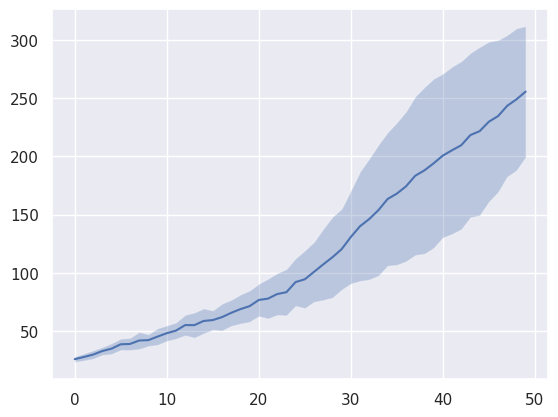

In [23]:
plot_line_collection(results)

Very awesome. You can see how all agents learned over time. We can interpret the results as:
 - It seems that all agents learned to keep the pole up for 250 steps on average after 50 epochs, while in the beginning this was only 25 steps.
 - Note that when creating the environment, we limited the maximum number of steps to 300, so it is very close to 'nailing' the environment.

### Evaluating an agent

It might not be entirely fair to use the average return of the episode while gathering experience.
While gathering experience, we *randomly sample* an action from the action distribution. However, when we want to know how well a policy works, we should actually see how it does when selecting *the most probable* action from the distribution during an episode.

Let's train a policy and evaluate it correctly.

In [24]:
policy, train_info = train_policy(env, n_epochs=50, n_episodes_per_epoch=100, learning_rate=1e-2, verbose=False)

In [25]:
print("Last average return:", train_info["returns"][-1])

Last average return: 238.4189453125


In [26]:
def evaluate_policy(env, policy, n_episodes=100, render=False):
    returns = []
    for _ in range(n_episodes):
        observation, _ = env.reset()
        episode_return = 0

        if render:
            screen = plt.imshow(env.render())
    
        done = False
        while not done:
            if render:
                screen.set_data(env.render())
                display.display(plt.gcf())
                display.clear_output(wait=True)

            with torch.no_grad():
                action_distribution = policy.get_action_distribution(observation)

            action = torch.argmax(action_distribution.probs).item()
            observation, reward, terminated, truncated, _ = env.step(action)
            episode_return += reward

            if terminated or truncated:
                done = True

        returns.append(episode_return)

    return np.mean(returns)

In [27]:
evaluate_policy(env, policy)

297.69

This means that on all 100 episodes the agent reached the maximum number of timesteps of the environment (rendering is extremely whack I'm sorry, does anyone know how to do this better?).

In [28]:
%matplotlib inline 

300.0

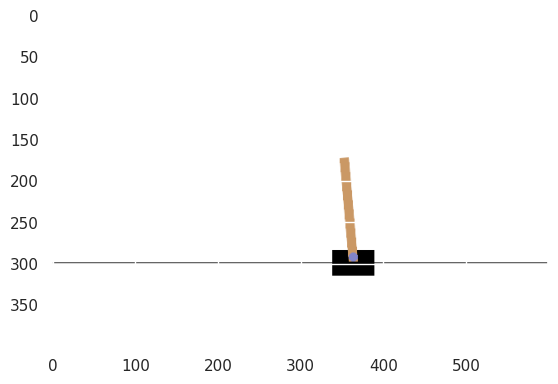

In [29]:
evaluate_policy(env, policy, n_episodes=1, render=True)

Very nice. It is a neural network that learned how to balance a pole.